Version log:
* 0.9 restart
    * using DQN lessons learned as template
* 0.10 fixed agent, oppo labels
* 0.11 horizontal, color swaps
* 0.12 learning not improved - dev paused or stopped
* 0.20 restarted with corrected  LA and ENV

## Links, learning from
[https://docs.pytorch.org/tutorials/intermediate/reinforcement_q_learning.html](https://docs.pytorch.org/tutorials/intermediate/reinforcement_q_learning.html)
<br>
[https://pettingzoo.farama.org/tutorials/agilerl/DQN/](https://pettingzoo.farama.org/tutorials/agilerl/DQN/)
<br>
[https://www.geeksforgeeks.org/machine-learning/understanding-prioritized-experience-replay/](https://www.geeksforgeeks.org/machine-learning/understanding-prioritized-experience-replay/)
<br>
### Other helpful links

<br>[https://medium.com/@vishwapatel214/building-a-connect-4-game-bot-with-deep-learning-models-dbcd019d8967](https://medium.com/@vishwapatel214/building-a-connect-4-game-bot-with-deep-learning-models-dbcd019d8967)
<br>[https://codebox.net/pages/connect4#:~:text=This%20requires%20a%20lot%20of%20work%20up%2Dfront,possible%20action%20at%20each%20step%20is%20impractical.](https://codebox.net/pages/connect4#:~:text=This%20requires%20a%20lot%20of%20work%20up%2Dfront,possible%20action%20at%20each%20step%20is%20impractical.)
<br>[https://medium.com/advanced-machine-learning/deep-learning-meets-board-games-creating-a-connect-4-ai-using-cnns-and-vits-89c8cdab0041](https://medium.com/advanced-machine-learning/deep-learning-meets-board-games-creating-a-connect-4-ai-using-cnns-and-vits-89c8cdab0041)
<br>[https://medium.com/@piyushkashyap045/understanding-dropout-in-deep-learning-a-guide-to-reducing-overfitting-26cbb68d5575#:~:text=Choosing%20Dropout%20Rate:%20Common%20dropout,is%20better%20for%20simpler%20models.](https://medium.com/@piyushkashyap045/understanding-dropout-in-deep-learning-a-guide-to-reducing-overfitting-26cbb68d5575#:~:text=Choosing%20Dropout%20Rate:%20Common%20dropout,is%20better%20for%20simpler%20models.)
<br>
[https://medium.com/oracledevs/lessons-from-alphazero-connect-four-e4a0ae82af68](https://medium.com/oracledevs/lessons-from-alphazero-connect-four-e4a0ae82af68)
<br>
[https://docs.agilerl.com/en/latest/tutorials/pettingzoo/dqn.html](https://docs.agilerl.com/en/latest/tutorials/pettingzoo/dqn.html)
<br>


## Import dependecies and recheck installation

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from torchinfo import summary
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import pprint;
import pandas as pd
import os
from IPython.display import display, clear_output

import warnings

print("All dependencies imported successfully.")
print("torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)

if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))
else:
    print("CUDA not available. Using CPU.")

# Device configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

All dependencies imported successfully.
torch version: 2.5.1
CUDA available: True
CUDA version: 11.8
GPU name: NVIDIA GeForce RTX 4090


### Fixed Random seeds

In [2]:
SEED = 666
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

os.environ["PYTHONHASHSEED"] = str(SEED)

## Constants

In [3]:
log_every_x_episode = 100
plot_interval = 10 

In [4]:
LOG_DIR ="Logs/PPQ/"
MODEL_DIR ="Models/PPQ/"
PLOTS = "Plots/PPQ/"

## Custom imports

In [5]:
from C4.connect4_env import Connect4Env
from C4.connect4_lookahead import Connect4Lookahead
from PPO.ppo_training_phases_config import TRAINING_PHASES
from PPO.actor_critic import ActorCritic
from PPO.ppo_buffer import PPOBuffer, PPOHyperParams
from PPO.ppo_update import ppo_update, PPOUpdateCfg
from C4.connect4_board_display import Connect4_BoardDisplayer
from C4.plot_phase_summary import plot_phase_summary
from PPO.ppo_utilities import (
    select_opponent_action, is_draw, PhaseTracker, display_phases_table, params_for_phase, encode_two_channel_agent_centric,
    _key_from_lookahead
)   
from PPO.ppo_live_plot import plot_live_training_ppo
from PPO.ppo_summary import (
    init_summary_stats, log_summary_stats_ppo,
    save_summary_stats_excel, sanitize_for_plot, summary_stats_df
)
from PPO.checkpoint import save_checkpoint, load_checkpoint
from DQN.dqn_utilities import update_benchmark_winrates
from PPO.ppo_eval_utilities import display_final_boards_ppo
from PPO.ppo_opponent_sampler import OpponentSampler

Lookahead = Connect4Lookahead()
summary_stats = init_summary_stats()

# Training phases

In [6]:
PHASES = PhaseTracker(TRAINING_PHASES)
L, lastPhase=display_phases_table(TRAINING_PHASES)
print(L, lastPhase)

phase,start_ep,end_ep,duration,lookahead,length,lr,clip,entropy,epochs
BootL1a,1,300,300,1,300,0.00016,0.22,0.012,4
Rinse,301,400,100,0,400,0.00016,0.22,0.008,3
BootL1b,401,700,300,1,700,0.00012,0.25,0.012,4
L2a,701,800,100,2,800,0.00016,0.10,0.004,4
L3a,801,900,100,2,900,0.00016,0.10,0.004,4
SPa,901,1000,100,-1,1000,0.00012,0.08,0.004,3


1000 SPa


# Training session name


In [7]:
#number_episodes = 300 
number_episodes = L # all
lookahead_depth = 7  # prophet = 7
begin_start_time = time.time()
model_name = "RANDOM2"
time_str = time.strftime('%Y-%m-%d %H-%M-%S', time.localtime(begin_start_time))
tag = f"{lastPhase} - {model_name}"
TRAINING_SESSION = f"PPQ-{number_episodes}-{tag} - at-{time_str}"
print("Start training session", TRAINING_SESSION)

Start training session PPQ-1000-SPa - RANDOM2 - at-2025-09-13 14-35-28


# PPO

In [8]:
ppo_model = ActorCritic(action_dim=7).to(DEVICE)
summary(ppo_model, input_size=(1, 1, 6, 7))

Layer (type:depth-idx)                   Output Shape              Param #
ActorCritic                              [1, 7]                    --
├─Conv2d: 1-1                            [1, 32, 6, 7]             608
├─Conv2d: 1-2                            [1, 64, 5, 6]             32,832
├─Flatten: 1-3                           [1, 1920]                 --
├─Linear: 1-4                            [1, 128]                  245,888
├─Linear: 1-5                            [1, 7]                    903
├─Linear: 1-6                            [1, 1]                    129
Total params: 280,360
Trainable params: 280,360
Non-trainable params: 0
Total mult-adds (M): 1.26
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 1.12
Estimated Total Size (MB): 1.15

### Load seeds

In [9]:
# === Load per-move dataset ===

DATA_PATH = "DATA/C4.play_data.xlsx"

ROWS, COLS = 6, 7
BOARD_COLS = [f"{r}-{c}" for r in range(ROWS) for c in range(COLS)]

DATA = pd.read_excel(DATA_PATH)
for c in BOARD_COLS:
    DATA[c] = DATA[c].astype("int8")
DATA["ply"]  = DATA["ply"].astype("int16")
DATA["game"] = DATA["game"].astype("int32")

print(f"Loaded DATA: {len(DATA):,} rows from {DATA_PATH}")


Loaded DATA: 4,731 rows from DATA/C4.play_data.xlsx


## Training Loop

In [10]:
# --- Logging / histories ---
win_history = []  

ppo_metrics_history = {
    "episodes": [],
    "loss_pi": [],
    "loss_v": [],
    "entropy": [],
    "approx_kl": [],
    "clip_frac": [],
    "explained_variance": [],
}

update_idx = 0
steps_collected = 0
reward_history = []              # per-episode total reward
benchmark_history  = None
win_count = loss_count = draw_count = 0
wins_hist, losses_hist, draws_hist = [], [], []

In [11]:
STEPS_PER_UPDATE    = 8192           # agent decisions per PPO update
LEARNING_RATE       = 3e-4
TEMPERATURE         = 1.0            # 0.0 = greedy sampling
ATTR_LOSS_TO_LAST   = True           # attribute opponent's terminal win to our last move
CLEAR_BUFFER_ON_PHASE_CHANGE = True  # ### CHANGED: avoid leaking rollouts across phases
BENCHMARK_EVERY     = 50

# --- Env / Policy / Optimizer / Buffer ---
env     = Connect4Env()
policy  = ActorCritic(action_dim=7).to(DEVICE)
optim   = torch.optim.Adam(policy.parameters(), lr=LEARNING_RATE, eps=1e-5)

hparams = PPOHyperParams(gamma=0.99, gae_lambda=0.95, normalize_adv=True)
buffer  = PPOBuffer(capacity=STEPS_PER_UPDATE * 2, action_dim=7, hparams=hparams)

cfg     = PPOUpdateCfg(
    epochs=4, batch_size=512,
    clip_range=0.20, vf_clip_range=0.20,
    ent_coef=0.01, vf_coef=0.5,
    max_grad_norm=0.5, target_kl=0.03
)

## load checkpoint

In [12]:
load_path = f"{model_name} PPQ model.pt" 
loaded_model, loaded_optim_state, meta = load_checkpoint(load_path, device=DEVICE, strict=True)

policy.load_state_dict(loaded_model.state_dict())

# 2) load optimizer state into your existing optim, then enforce current LR schedule
if loaded_optim_state is not None:
    optim.load_state_dict(loaded_optim_state)
    for g in optim.param_groups:
        g["lr"] = LEARNING_RATE

policy.eval() 

print(f"[ckpt] loaded into existing policy from: {load_path}")
if meta:
    print(f"[ckpt] meta: episode={meta.get('episode')} lk={meta.get('lookahead_depth')} ts={meta.get('timestamp')}")

[ckpt] loaded into existing policy from: RANDOM2 PPQ model.pt
[ckpt] meta: episode=700 lk=-1 ts=20250912-181141


## Seeding

In [13]:
from PPO.ppo_bc_seed import bc_pretrain_actor
from PPO.ppo_bc_seed_adapters import iter_moves_for_bc

bc_stats = bc_pretrain_actor(
    policy=policy,
    samples_iterable=iter_moves_for_bc(DATA, verbose=True),
    epochs=3,
    batch_size=4096,
    lr=3e-4,
    ent_coef=0.0,
    max_grad_norm=0.5,
    verbose=True,
)
policy.eval()


[BC-adapter] games=151, samples_emitted=4731, skipped_games=0
[BC] Epoch 1/3 | CE=1.6250 | Ent=1.6198
[BC] Epoch 2/3 | CE=1.6279 | Ent=1.6425
[BC] Epoch 3/3 | CE=1.6307 | Ent=1.6524
[BC] Done in 0.6s | Samples: 4731


ActorCritic(
  (conv1): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=1920, out_features=128, bias=True)
  (policy_head): Linear(in_features=128, out_features=7, bias=True)
  (value_head): Linear(in_features=128, out_features=1, bias=True)
)

In [14]:
# --- behavior logprob/value recomputation for augmented variants ---
def recompute_lp_val(state_np, action_int, legal_mask_np):
    s = torch.from_numpy(state_np).unsqueeze(0).to(DEVICE).float()      # [1,*,6,7]
    logits, v = policy.forward(s)                                       # [1,A], [1]
    lm = torch.from_numpy(legal_mask_np).unsqueeze(0).to(DEVICE)        # [1,A]
    lm = lm.to(dtype=torch.bool)

    # Guard: ensure at least one legal action
    if lm.sum().item() == 0:
        lm = torch.ones_like(lm, dtype=torch.bool)

    masked = logits.masked_fill(~lm, -1e9)

    temp = max(float(TEMPERATURE), 1e-6)
    log_probs = torch.log_softmax(masked / temp, dim=-1) if TEMPERATURE > 0 else torch.log_softmax(masked, dim=-1)

    lp = log_probs[0, int(action_int)]
    return lp.detach(), v.squeeze(0).detach()

In [15]:
# --- opponent overlay / logging helpers ---
opponent_timeline: list[str] = []   # one short key per episode -> drives the overlay
sampled_opponent_key: str | None = None
phase_mix: dict[str, float] = {"R": 1.0}  # default shown in logs (no effect yet)


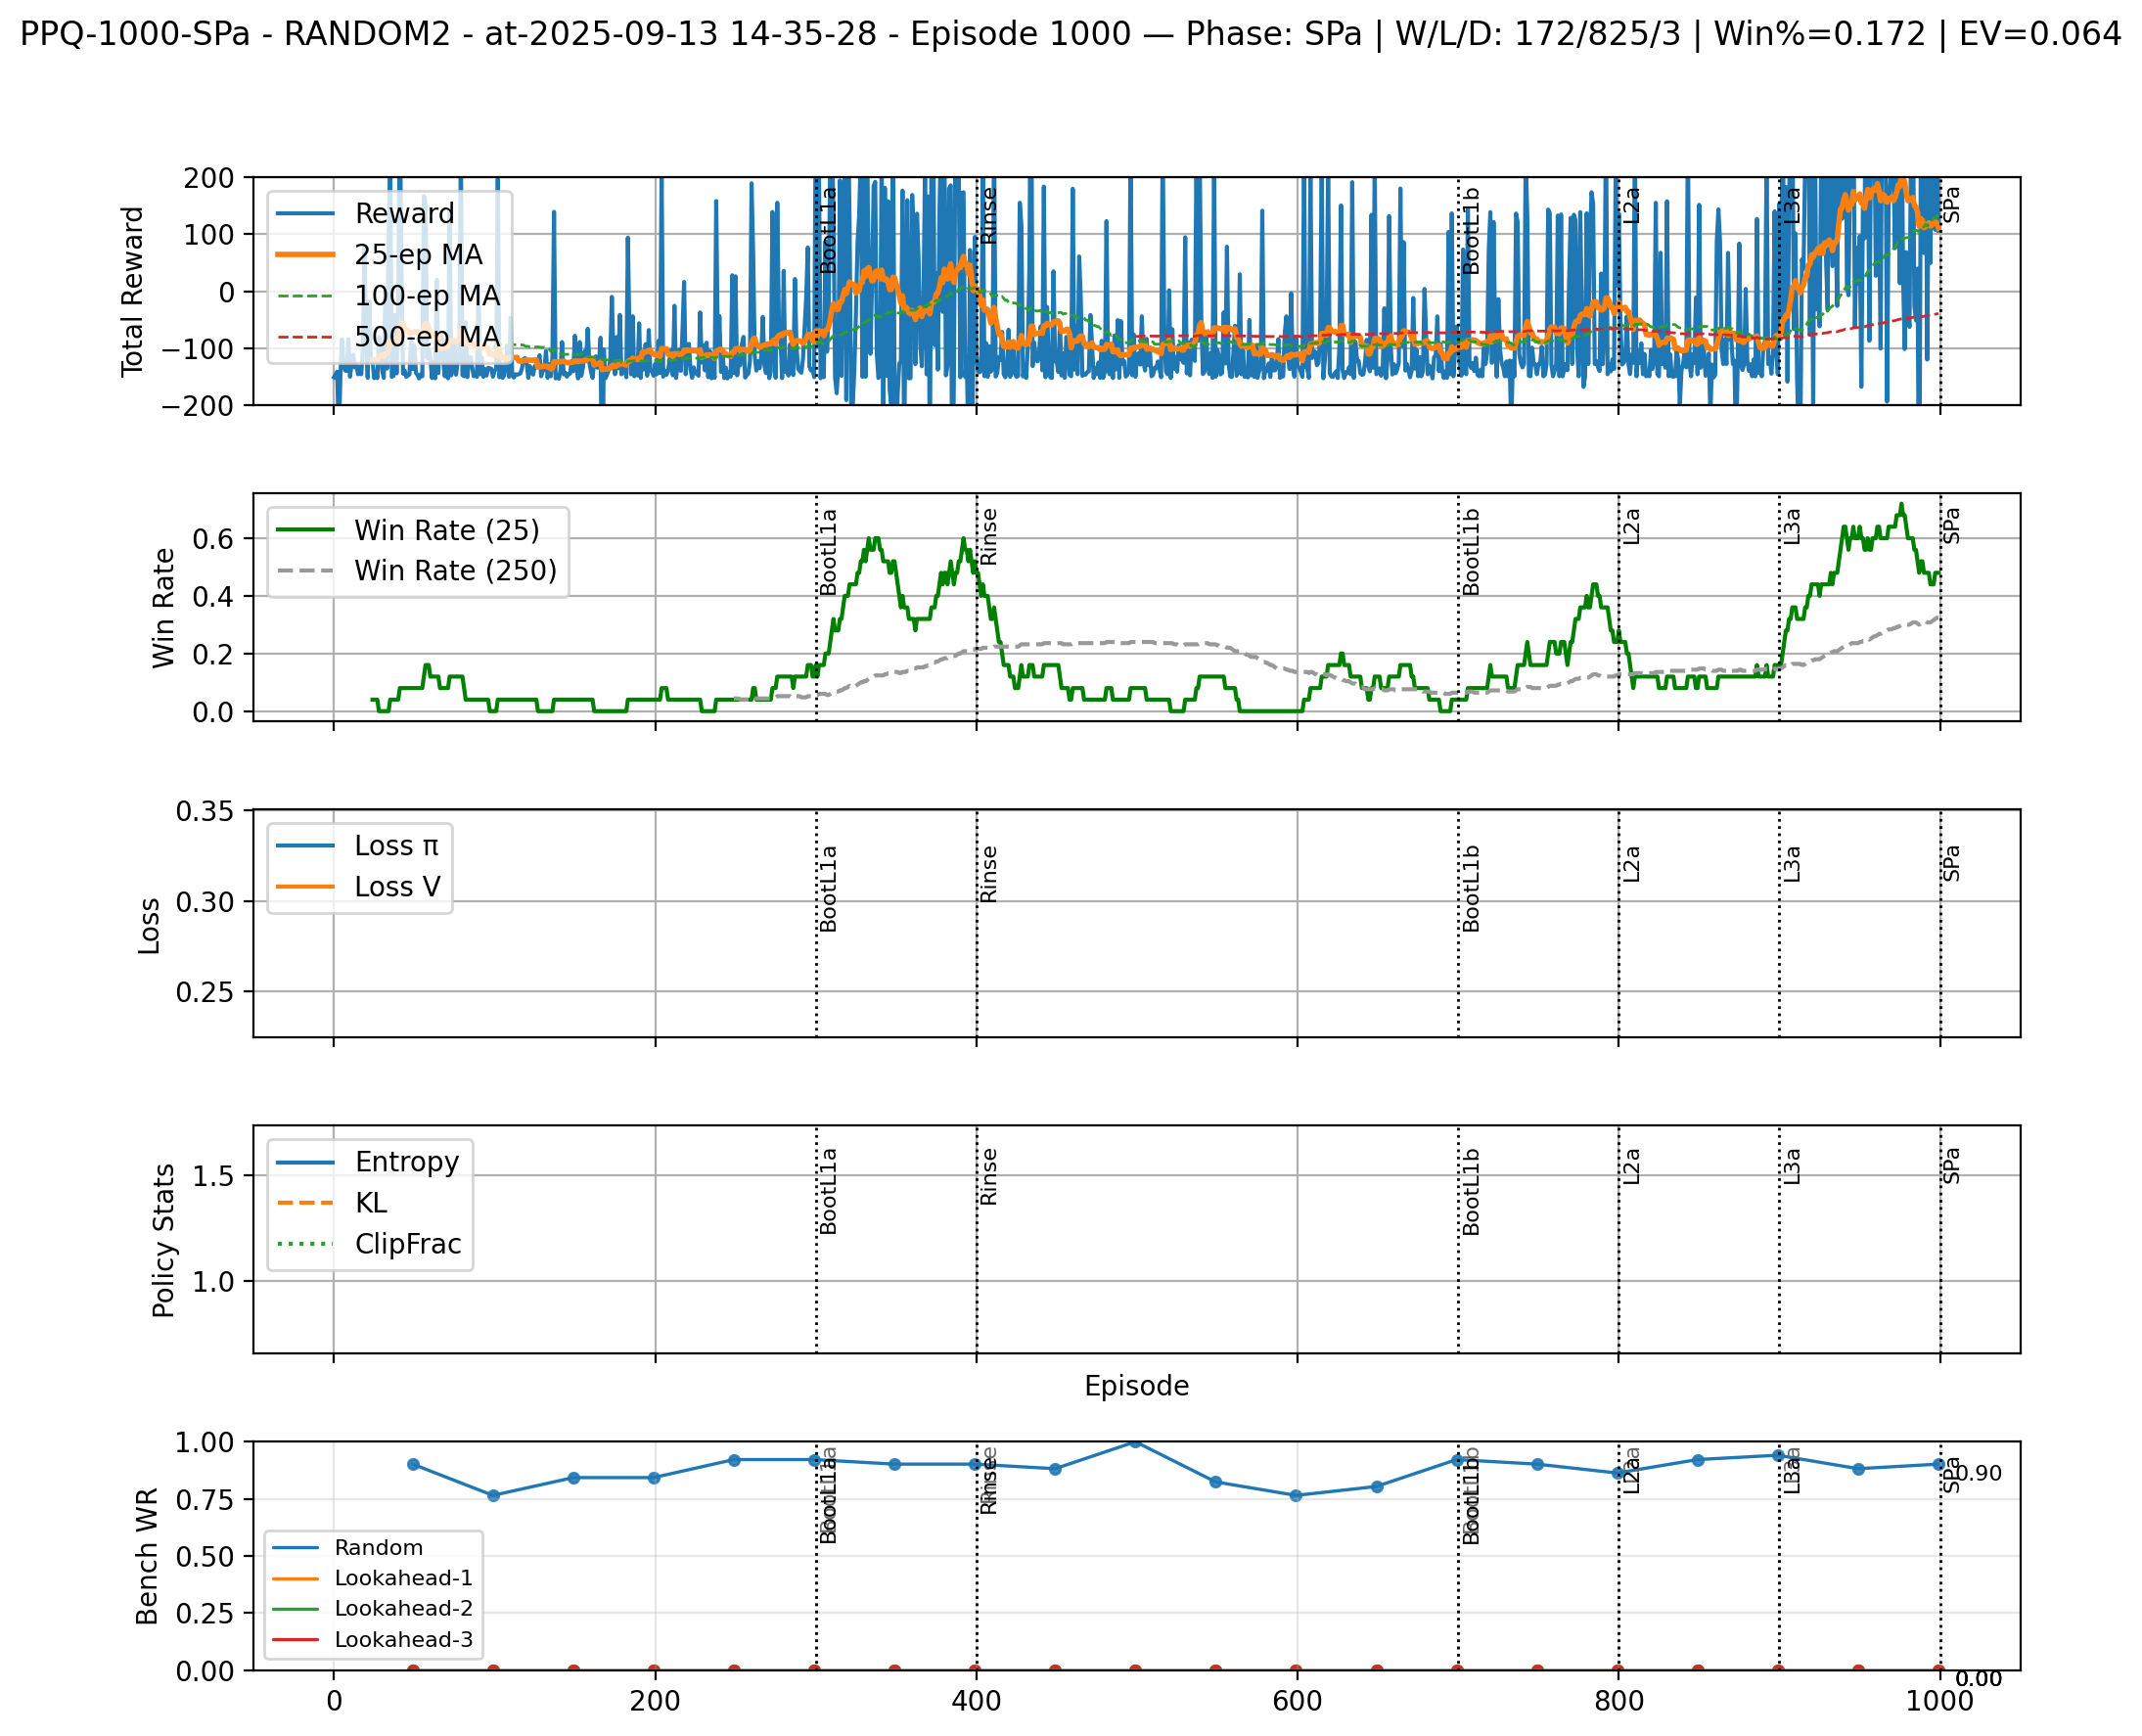

[Saved] Plots/PPQ/PPQ-1000-SPa - RANDOM2 - at-2025-09-13 14-35-28__complete_training_plot.png
Training finished in 28.7 min


In [16]:
# ============================
# PPO TRAINING LOOP 
# ============================

start_time = time.time()

AUG_MULT = 4
REWARD_SCALE = getattr(buffer, "reward_scale", 0.01)

_state_for_bootstrap = None
_next_player_for_bootstrap = None
_done_for_bootstrap = True
current_phase_name = None
lookahead_depth = None
steps_collected = 0
update_idx = 0
last_agent_reward_entries = None

with tqdm(total=number_episodes, desc="Episodes") as epbar:
    opponent_sampler = None  # (re)built on phase change

    for episode in range(1, number_episodes + 1):
        phase_info, changed = PHASES.start_episode(episode)
        current_phase_name = phase_info.name

        if changed:
            # ---- phase params ----
            lookahead_depth = phase_info.lookahead
            phase_params = params_for_phase(current_phase_name, cfg)

            for g in optim.param_groups:
                g["lr"] = phase_params["lr"]

            cfg.clip_range     = phase_params["clip"]
            cfg.ent_coef       = phase_params["entropy"]
            cfg.epochs         = phase_params["epochs"]
            cfg.target_kl      = phase_params["target_kl"]
            cfg.vf_coef        = phase_params["vf_coef"]
            cfg.vf_clip_range  = phase_params["vf_clip"]
            cfg.batch_size     = phase_params["batch_size"]
            cfg.max_grad_norm  = phase_params["max_grad_norm"]
            TEMPERATURE        = phase_params["temperature"]

            new_spu = phase_params.get("steps_per_update", 0)
            if new_spu and new_spu != STEPS_PER_UPDATE:
                STEPS_PER_UPDATE = new_spu
                buffer = PPOBuffer(
                    capacity=STEPS_PER_UPDATE * AUG_MULT + 512,
                    action_dim=7,
                    hparams=hparams,
                    reward_scale=REWARD_SCALE,
                )
                steps_collected = 0
                last_agent_reward_entries = None

            if CLEAR_BUFFER_ON_PHASE_CHANGE:
                buffer.clear()
                steps_collected = 0
                last_agent_reward_entries = None

            # ---- build opponent sampler for this phase ----
            phase_mix_cfg = TRAINING_PHASES[current_phase_name].get("opponent_mix", None)
            if phase_mix_cfg:
                phase_mix = {str(k): float(v) for k, v in phase_mix_cfg.items()}
            else:
                phase_mix = {_key_from_lookahead(lookahead_depth): 1.0}
            opponent_sampler = OpponentSampler(phase_mix, seed=episode)

        # ---- choose opponent for this episode ----
        sampled_key = opponent_sampler.sample_key() if opponent_sampler else _key_from_lookahead(lookahead_depth)
        lookahead_depth = OpponentSampler.key_to_mode(sampled_key)
        opponent_timeline.append(sampled_key)  # for overlay

        # === Episode loop ===
        state = env.reset()
        ep_return = 0.0
        episode_win_flag = 0
        last_agent_reward_entries = None

        agent_starts = (episode % 2 == 1)
        next_player = +1 if agent_starts else -1
        env.current_player = next_player

        while not env.done:
            if next_player == +1:
                # --- Agent turn (+1) ---
                legal_actions = env.available_actions()
                if not legal_actions:           # rare stalemate guard
                    draw_count += 1
                    break

                legal_mask = np.zeros(7, dtype=bool)
                legal_mask[legal_actions] = True

                enc_state = encode_two_channel_agent_centric(env.board, +1)
                action, logprob, value, _ = policy.act(enc_state, legal_actions, temperature=TEMPERATURE)

                env.current_player = +1
                next_state, reward, _ = env.step(action)
                ep_return += reward

                last_agent_reward_entries = buffer.add_augmented(
                    state_np=enc_state, action=action, logprob=logprob, value=value,
                    reward=reward, done=env.done, legal_mask_bool=legal_mask,
                    hflip=True, colorswap=False, include_original=True,
                    recompute_fn=recompute_lp_val
                )

                steps_collected += 1
                state = next_state

                if env.done:
                    if env.winner == 0:
                        draw_count += 1
                    elif env.winner == +1:
                        win_count += 1; episode_win_flag = 1
                    else:
                        loss_count += 1
                    break

                next_player = -1
                env.current_player = -1

            else:
                # --- Opponent turn (-1) ---
                legal_actions = env.available_actions()
                if not legal_actions:
                    draw_count += 1
                    break

                if lookahead_depth == "self":
                    enc_state_opp = encode_two_channel_agent_centric(env.board, -1)
                    opp_action, _, _, _ = policy.act(enc_state_opp, legal_actions, temperature=TEMPERATURE)
                else:
                    opp_action = select_opponent_action(env.board.copy(), player=-1, depth=lookahead_depth)

                if opp_action is None:
                    draw_count += 1
                    break

                env.current_player = -1
                state_after_opp, opp_reward, _ = env.step(opp_action)

                if env.done:
                    if env.winner == 0:
                        draw_count += 1
                    elif env.winner == -1:
                        loss_count += 1
                        if ATTR_LOSS_TO_LAST and last_agent_reward_entries:
                            buffer.add_penalty_to_entries(last_agent_reward_entries, env.LOSS_PENALTY, scale_raw=True)
                        ep_return += env.LOSS_PENALTY
                    state = state_after_opp
                    break

                state = state_after_opp
                next_player = +1
                env.current_player = +1

            # ---- PPO update when enough AGENT decisions collected ----
            if steps_collected >= STEPS_PER_UPDATE:
                update_idx += 1

                last_done = True
                last_value = 0.0
                if next_player == +1:
                    with torch.no_grad():
                        enc_boot = encode_two_channel_agent_centric(env.board, +1)
                        inp = torch.from_numpy(enc_boot).unsqueeze(0).to(DEVICE).float()
                        _, v_boot = policy.forward(inp)
                        last_value = float(v_boot.squeeze().item())
                    last_done = False

                buffer.compute_gae(last_value=last_value, last_done=last_done)
                metrics = ppo_update(policy, optim, buffer, cfg)

                ppo_metrics_history["episodes"].append(episode)
                for k in ["loss_pi","loss_v","entropy","approx_kl","clip_frac","explained_variance"]:
                    ppo_metrics_history[k].append(metrics[k])

                buffer.clear()
                steps_collected = 0
                last_agent_reward_entries = None

        # === episode ended ===
        reward_history.append(ep_return)
        wins_hist.append(win_count); losses_hist.append(loss_count); draws_hist.append(draw_count)
        win_history.append(episode_win_flag)
        epbar.update(1)

        # periodic benchmarking
        if (episode + 1) % BENCHMARK_EVERY == 0 or episode == 0:
            benchmark_history = update_benchmark_winrates(
                agent=policy, env=env, device=DEVICE, Lookahead=Connect4Lookahead,
                episode=episode, history=benchmark_history,
                save=f"{LOG_DIR}{TRAINING_SESSION}-benchmark.xlsx"
            )

        # live plot
        if (episode + 1) % plot_interval == 0:
            plot_live_training_ppo(
                episode=episode,
                reward_history=reward_history,
                win_history=win_history,
                phase_name=current_phase_name,
                win_count=win_count, loss_count=loss_count, draw_count=draw_count,
                metrics_history=ppo_metrics_history,
                benchmark_history=benchmark_history,
                title=TRAINING_SESSION,
                phases=TRAINING_PHASES,
                save=False,
                save_path=PLOTS,
                opponent_timeline=opponent_timeline,
                overlay_last=100
            )

        if (episode + 1) % log_every_x_episode == 0 or episode == 1:
            phase_mix_for_log = TRAINING_PHASES[current_phase_name].get("opponent_mix", {sampled_key: 1.0})
            strategy_weights = {"mix": phase_mix_for_log, "sampled": sampled_key}
            log_summary_stats_ppo(
                summary_stats,
                episode=episode,
                phase_name=current_phase_name,
                lookahead_depth=lookahead_depth,
                reward_history=reward_history,
                win_history=win_history,
                win_count=win_count, loss_count=loss_count, draw_count=draw_count,
                ppo_metrics_history=ppo_metrics_history,
                steps_per_update=STEPS_PER_UPDATE,
                lr=optim.param_groups[0]["lr"],
                epsilon=None,
                strategy_weights=strategy_weights,
            )

        _state_for_bootstrap = env.board.copy()
        _next_player_for_bootstrap = next_player
        _done_for_bootstrap = env.done

# --- Final update on leftover samples (if any) ---
if len(buffer) > 0:
    last_done = True
    last_value = 0.0
    if not _done_for_bootstrap and _next_player_for_bootstrap == +1:
        with torch.no_grad():
            enc_boot = encode_two_channel_agent_centric(_state_for_bootstrap, +1)
            inp = torch.from_numpy(enc_boot).unsqueeze(0).to(DEVICE).float()
            _, v_boot = policy.forward(inp)
            last_value = float(v_boot.squeeze().item())
        last_done = False

    buffer.compute_gae(last_value=last_value, last_done=last_done)
    metrics = ppo_update(policy, optim, buffer, cfg)

    ppo_metrics_history["episodes"].append(episode)
    for k in ["loss_pi","loss_v","entropy","approx_kl","clip_frac","explained_variance"]:
        ppo_metrics_history[k].append(metrics[k])

plot_live_training_ppo(
    episode=episode,
    reward_history=reward_history,
    win_history=win_history,
    phase_name=current_phase_name or PHASES.current_name,
    win_count=win_count, loss_count=loss_count, draw_count=draw_count,
    metrics_history=ppo_metrics_history,
    benchmark_history=benchmark_history,
    title=TRAINING_SESSION,
    phases=TRAINING_PHASES,
    save=True,
    save_path=PLOTS
)

print("Training finished in {:.1f} min".format((time.time() - start_time) / 60))


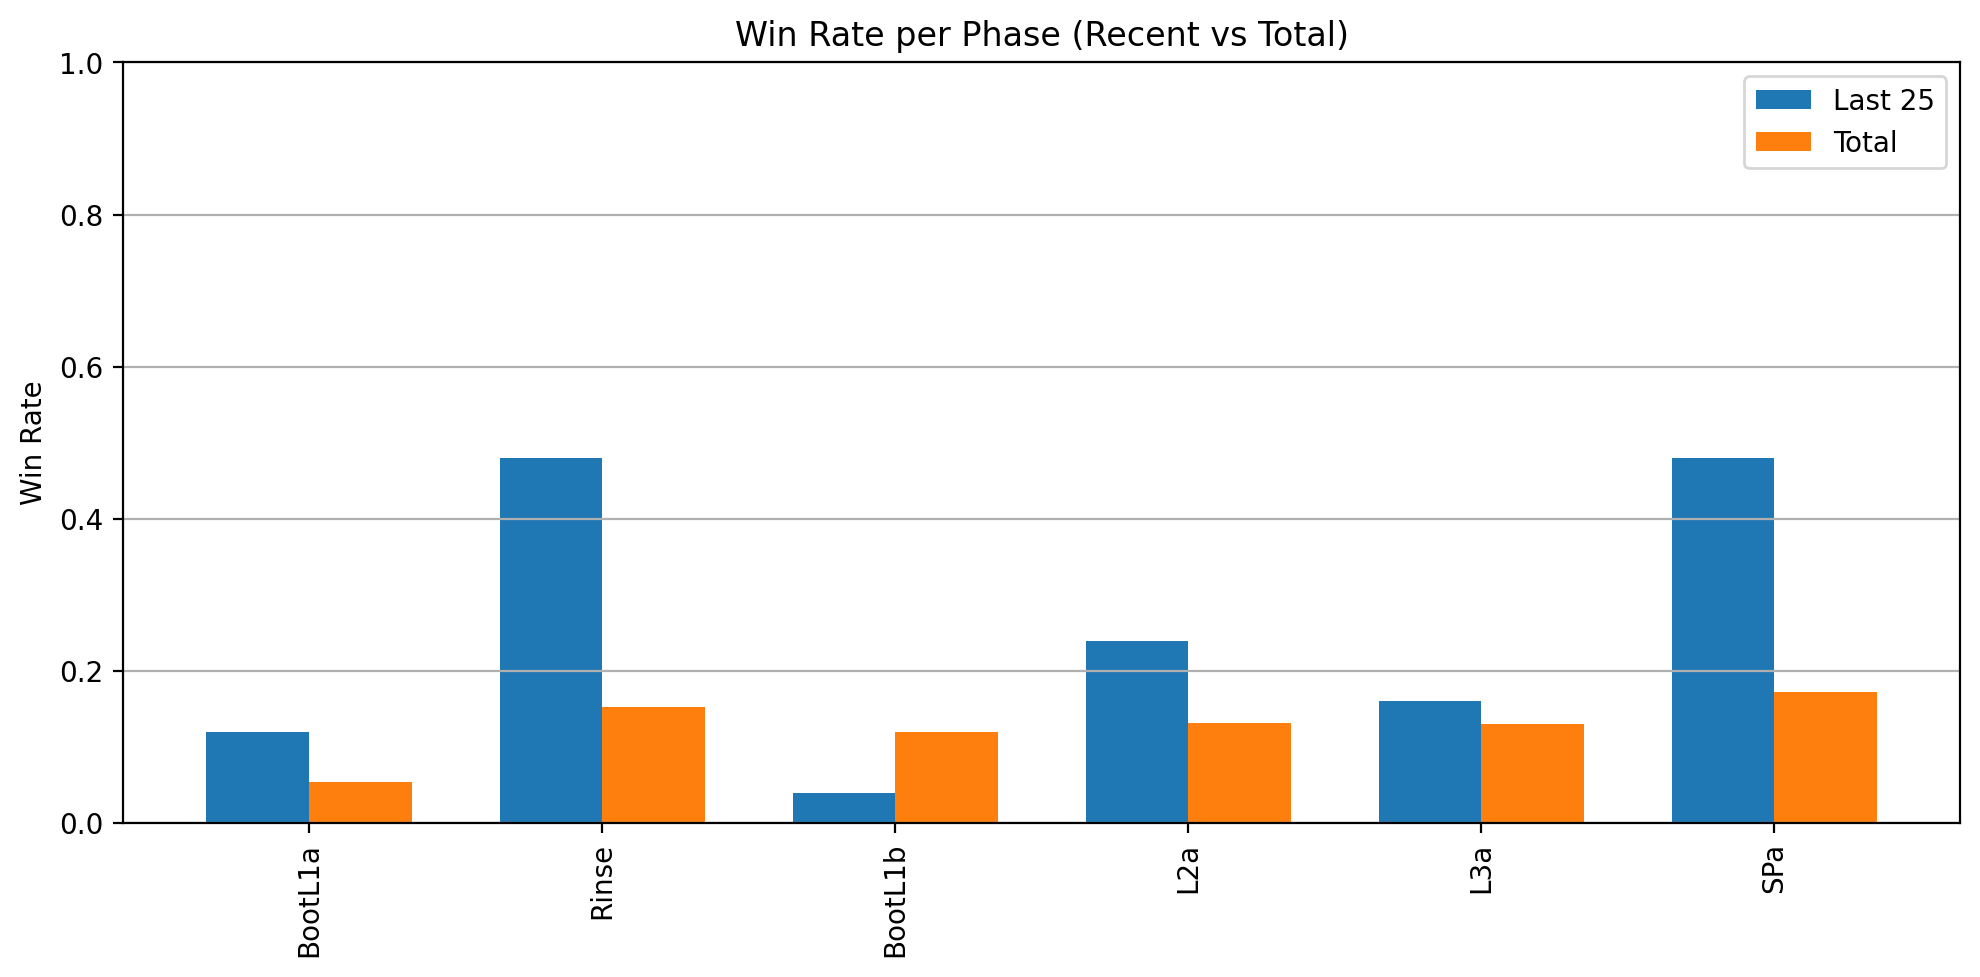

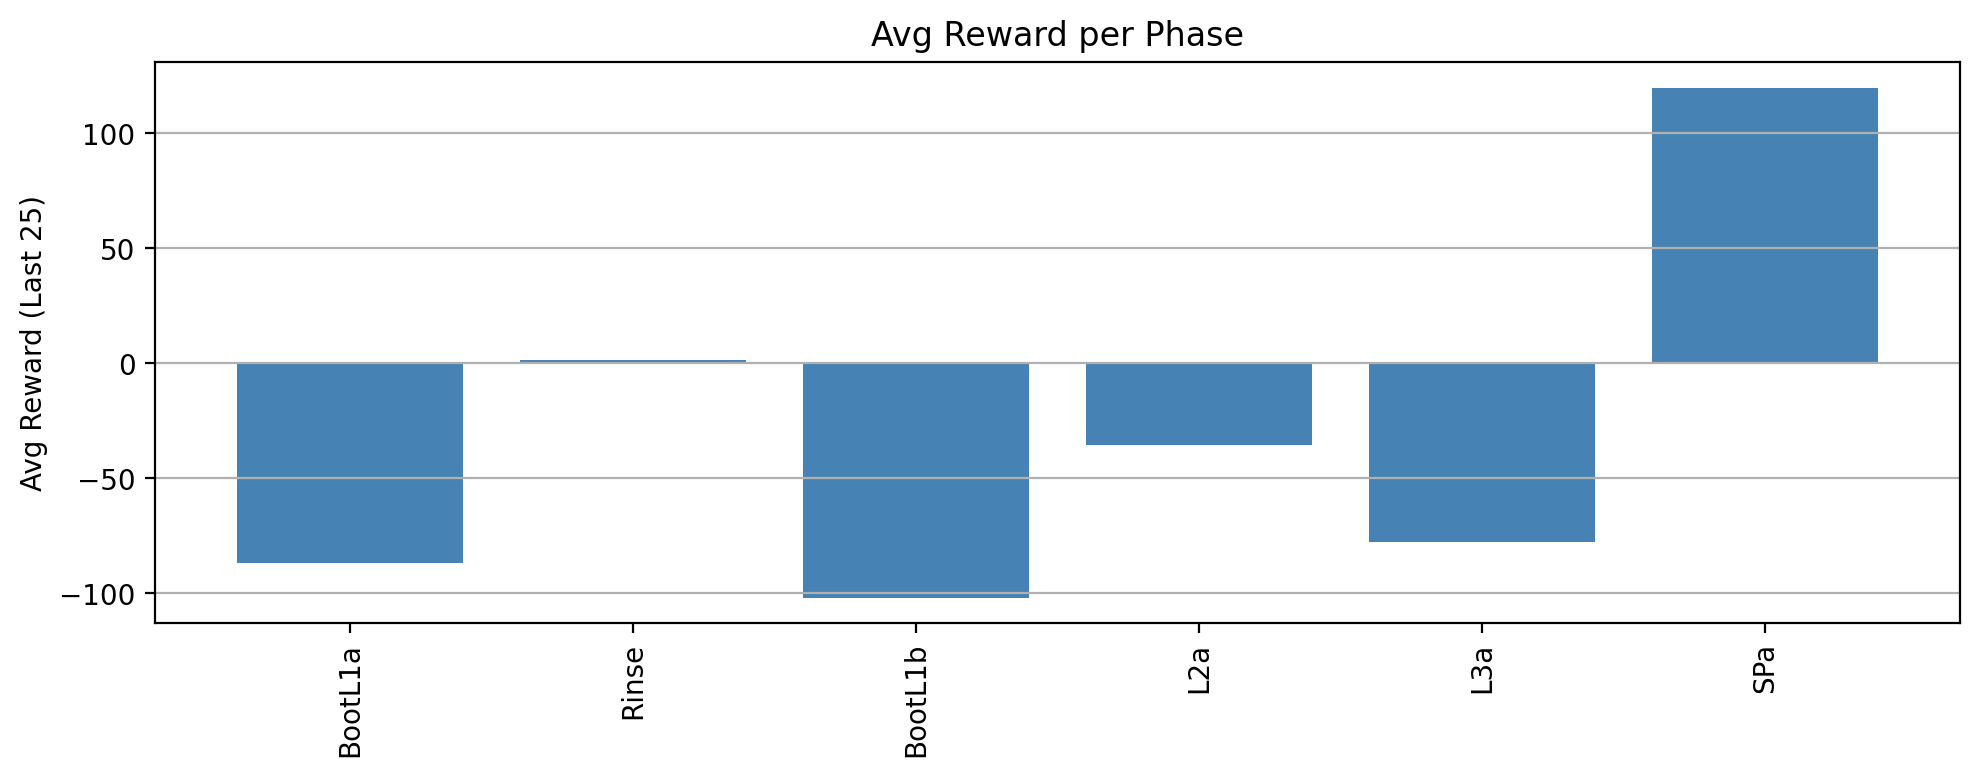

In [17]:
plot_phase_summary(summary_stats, TRAINING_PHASES)

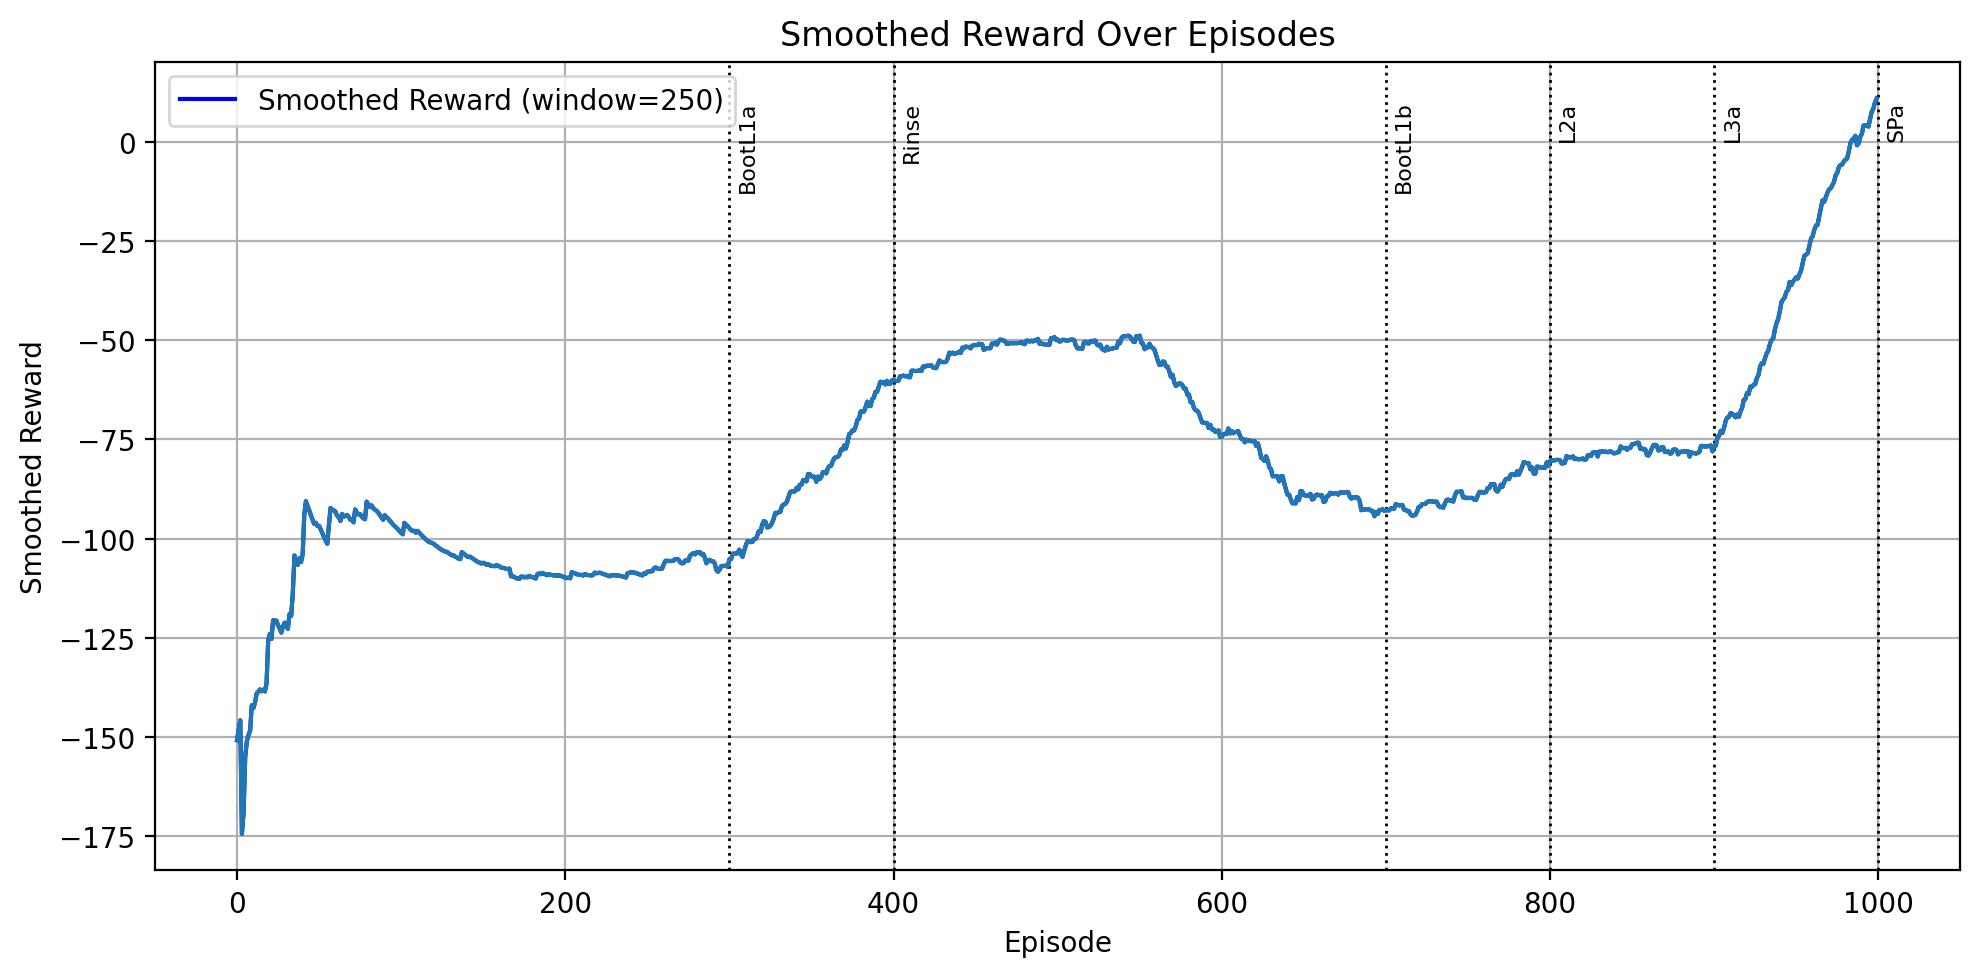

In [18]:
window = 250
smoothed = [np.mean(reward_history[max(0, i-window):i+1]) for i in range(len(reward_history))]

final_reward_fig, final_reward_ax = plt.subplots(figsize=(10, 5))
final_reward_ax.plot(smoothed, label=f"Smoothed Reward (window={window})", color='blue')

# --- Add phase transitions ---
for name, meta in TRAINING_PHASES.items():
    ep = meta["length"]
    if ep is not None and ep <= len(reward_history):
        final_reward_ax.axvline(x=ep, color='black', linestyle='dotted', linewidth=1)
        final_reward_ax.text(ep + 5, max(smoothed) * 0.95, name,
                             rotation=90, va='top', ha='left', fontsize=8)

final_reward_ax.set_title("Smoothed Reward Over Episodes")
final_reward_ax.set_xlabel("Episode")
final_reward_ax.set_ylabel("Smoothed Reward")
final_reward_ax.legend()
final_reward_ax.grid(True)
final_reward_fig.tight_layout()

plt.plot(smoothed)
plt.show()

In [19]:
df_summary = pd.DataFrame.from_dict(summary_stats, orient="index")
df_summary.to_excel(f"{LOG_DIR}PPO-{TRAINING_SESSION}_summary.xlsx", index=True)

## Save model

In [20]:
timestamp = time.strftime("%Y%m%d-%H%M%S")
model_path = f"{MODEL_DIR}{TRAINING_SESSION}_Connect4 ppo_model_{timestamp} episodes-{number_episodes} lookahead-{lookahead_depth}.pt"
default_model_path = "Connect4 PPQ model.pt"   

model_path, default_model_path = save_checkpoint(
    policy=policy,
    optim=optim,
    episode=episode,
    lookahead_depth=lookahead_depth,
    cfg=cfg,
    hparams=hparams,
    model_path=model_path,
    default_model_path=default_model_path,
)
print(f"Model saved to {model_path}\nAlso wrote: {default_model_path}")

Model saved to Models/PPQ/PPQ-1000-SPa - RANDOM2 - at-2025-09-13 14-35-28_Connect4 ppo_model_20250913-150417 episodes-1000 lookahead-self.pt
Also wrote: Connect4 PPQ model.pt


# Evaluation

In [21]:
# === PPO EVALUATION (agent is always +1; alternating starts) ===

import time, random
import numpy as np
import torch
from tqdm import tqdm

# --- Config ---
evaluation_opponents = {
    "Random":      201,
    "Lookahead-1": 101,
    "Lookahead-2":  10,
    "Lookahead-3":  10,   # raise later if you want
    # "Lookahead-5": 10,
    # "Lookahead-7":  5,
}

TEMPERATURE_EVAL = 0.0  # greedy / argmax

# Fresh env + lookahead
eval_env  = Connect4Env()
look_eval = Connect4Lookahead()

evaluation_results = {}
start_time = time.time()

with torch.inference_mode():
    for label, num_games in evaluation_opponents.items():
        wins = losses = draws = 0
        depth = int(label.split("-")[1]) if label.startswith("Lookahead") else None

        with tqdm(total=num_games, desc=f"Opponent: {label}") as pbar:
            for game_index in range(num_games):
                eval_env.reset()

                # --- Alternate who starts; AGENT is ALWAYS +1 ---
                agent_starts = (game_index % 2 == 0)
                eval_env.current_player = 1 if agent_starts else -1
                done = False

                while not done:
                    if eval_env.current_player == 1:
                        # ---------------- Agent move (greedy) ----------------
                        legal_actions = eval_env.available_actions()
                        enc_state = encode_two_channel_agent_centric(eval_env.board, +1)
                        action, _, _, _ = policy.act(enc_state, legal_actions=legal_actions, temperature=TEMPERATURE_EVAL)

                    else:
                        # ---------------- Opponent move ----------------
                        legal_actions = eval_env.available_actions()
                        if label == "Random":
                            action = random.choice(legal_actions)
                        else:
                            # lookahead plays as -1 (opponent)
                            a = look_eval.n_step_lookahead(eval_env.board.copy(), player=-1, depth=depth)
                            action = a if a in legal_actions else random.choice(legal_actions)

                    # Step env; we ignore reward here (only outcomes matter)
                    state, _, done = eval_env.step(action)

                # --- Tally result (agent is +1) ---
                if eval_env.winner == 1:
                    wins += 1
                elif eval_env.winner == -1:
                    losses += 1
                else:
                    draws += 1

                pbar.update(1)

        evaluation_results[label] = {
            "wins": wins,
            "losses": losses,
            "draws": draws,
            "win_rate": round(wins / num_games, 3),
            "loss_rate": round(losses / num_games, 3),
            "draw_rate": round(draws / num_games, 3),
        }

elapsed = time.time() - start_time
print(f"Evaluation completed in {elapsed/60:.1f} minutes\n")
for k, v in evaluation_results.items():
    print(f"{k:>12}: W {v['wins']:>4} | L {v['losses']:>4} | D {v['draws']:>4} "
          f"| WR {v['win_rate']:.3f} LR {v['loss_rate']:.3f} DR {v['draw_rate']:.3f}")


Opponent: Lookahead-3: 100%|██████████| 10/10 [00:44<00:00,  4.44s/it]

Evaluation completed in 1.5 minutes

      Random: W  182 | L   19 | D    0 | WR 0.905 LR 0.095 DR 0.000
 Lookahead-1: W    0 | L  101 | D    0 | WR 0.000 LR 1.000 DR 0.000
 Lookahead-2: W    0 | L   10 | D    0 | WR 0.000 LR 1.000 DR 0.000
 Lookahead-3: W    0 | L   10 | D    0 | WR 0.000 LR 1.000 DR 0.000


📊 Evaluation Summary:
     Random: 182W / 19L / 0D → Win 90.5% | Loss 9.5% | Draw 0.0%
Lookahead-1: 0W / 101L / 0D → Win 0.0% | Loss 100.0% | Draw 0.0%
Lookahead-2: 0W / 10L / 0D → Win 0.0% | Loss 100.0% | Draw 0.0%
Lookahead-3: 0W / 10L / 0D → Win 0.0% | Loss 100.0% | Draw 0.0%


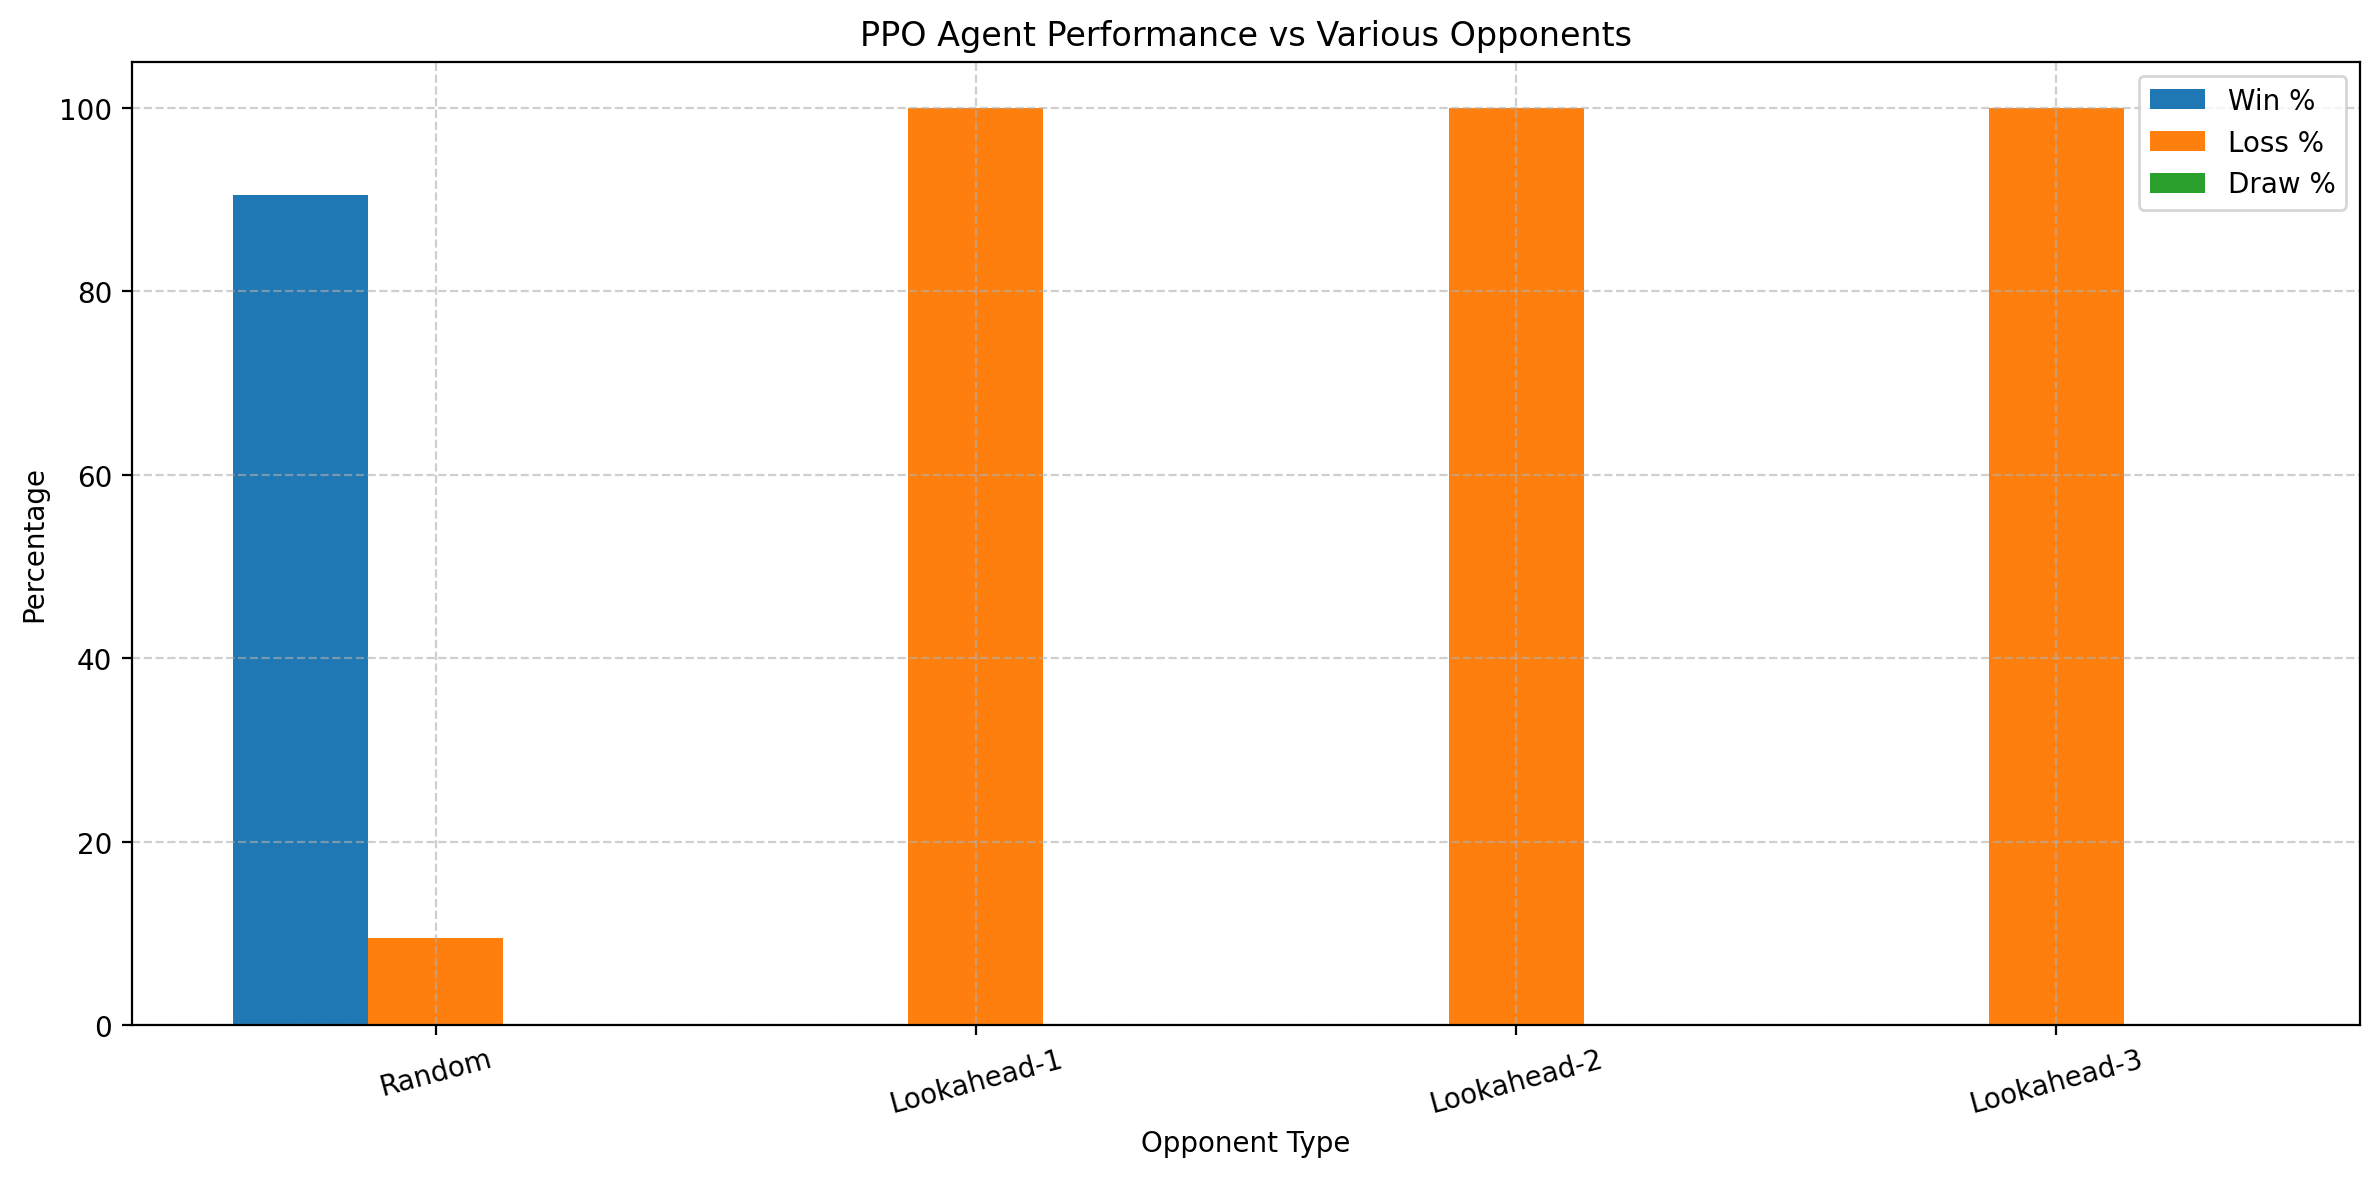

Evaluation results saved to Logs/PPQ/PPQ-1000-SPa - RANDOM2 - at-2025-09-13 14-35-28_PPO_evaluation_results.xlsx


In [22]:
# --- Text summary ---
print("📊 Evaluation Summary:")
for label, s in evaluation_results.items():
    print(f"{label:>11}: {s['wins']}W / {s['losses']}L / {s['draws']}D → "
          f"Win {s['win_rate']*100:.1f}% | Loss {s['loss_rate']*100:.1f}% | Draw {s['draw_rate']*100:.1f}%")

# --- Plot ---
labels = list(evaluation_results.keys())
win_rates  = [evaluation_results[k]['win_rate'] * 100 for k in labels]
loss_rates = [evaluation_results[k]['loss_rate'] * 100 for k in labels]
draw_rates = [evaluation_results[k]['draw_rate'] * 100 for k in labels]

x = np.arange(len(labels))
bar_width = 0.25

plt.figure(figsize=(12, 6))
plt.bar(x, win_rates, width=bar_width, label='Win %')
plt.bar(x + bar_width, loss_rates, width=bar_width, label='Loss %')
plt.bar(x + 2*bar_width, draw_rates, width=bar_width, label='Draw %')
plt.xlabel('Opponent Type')
plt.ylabel('Percentage')
plt.title('PPO Agent Performance vs Various Opponents')
plt.xticks(x + bar_width, labels, rotation=15)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# --- Save evaluation table to Excel ---
df_eval = pd.DataFrame.from_dict(evaluation_results, orient='index')
df_eval.index.name = "Opponent"
save_path = f"{LOG_DIR}{TRAINING_SESSION}_PPO_evaluation_results.xlsx"
os.makedirs(LOG_DIR, exist_ok=True)
df_eval.to_excel(save_path, index=True)
print(f"Evaluation results saved to {save_path}")

### Boards


🎯 Opponent: Random


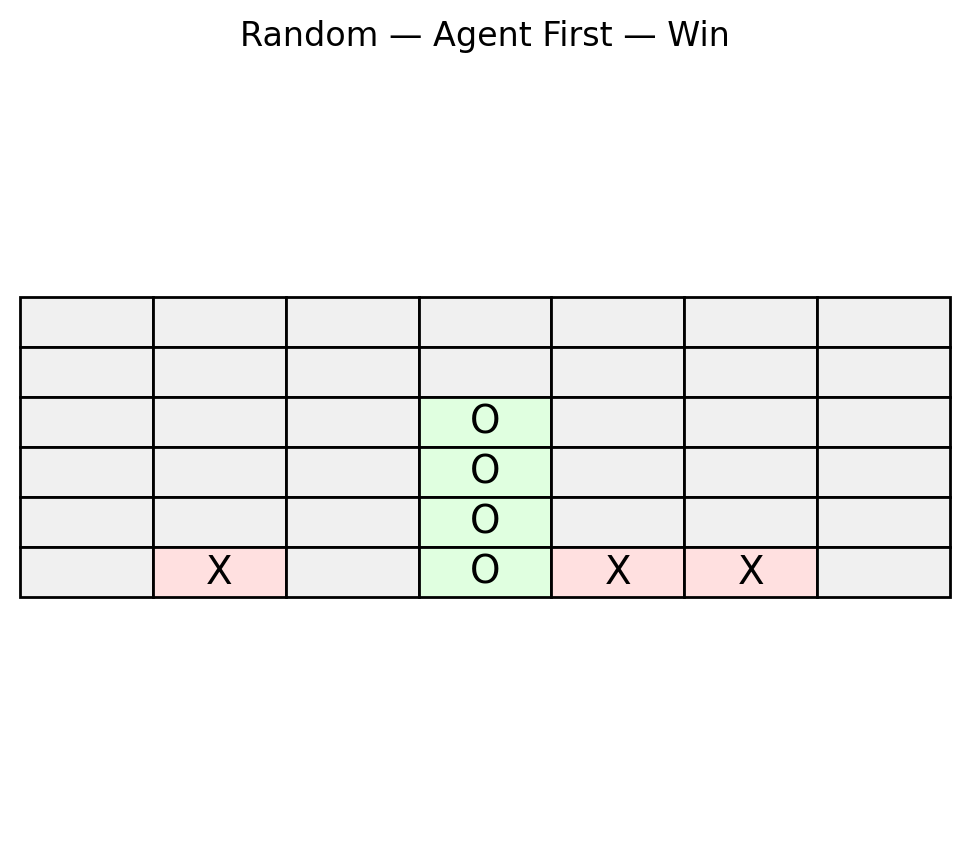

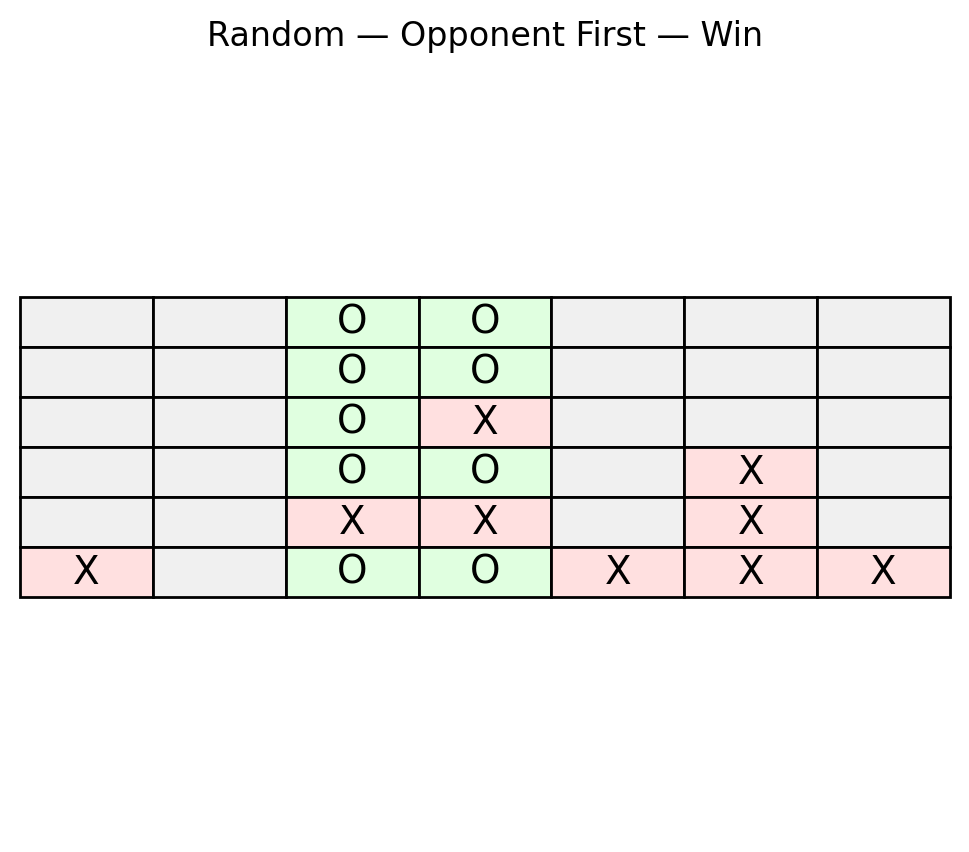

In [23]:
display_final_boards_ppo(policy=policy, env=env, opponents=["Random"], lookahead_impl=Lookahead, temperature=0.0)


🎯 Opponent: Lookahead-1


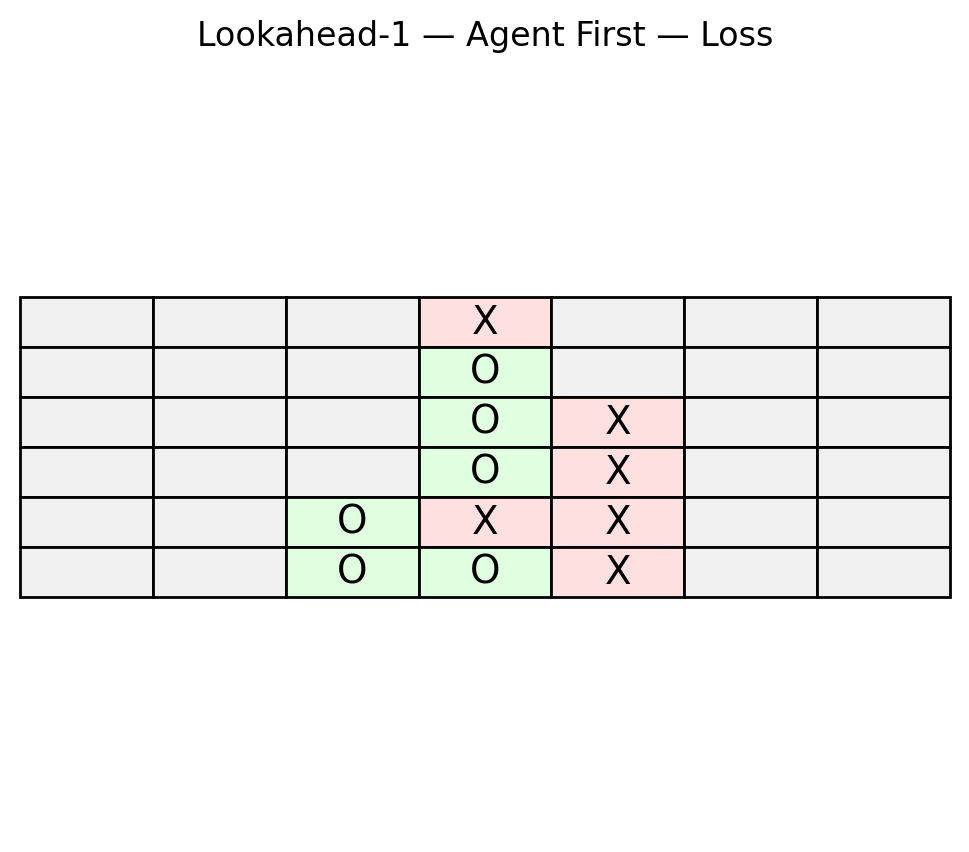

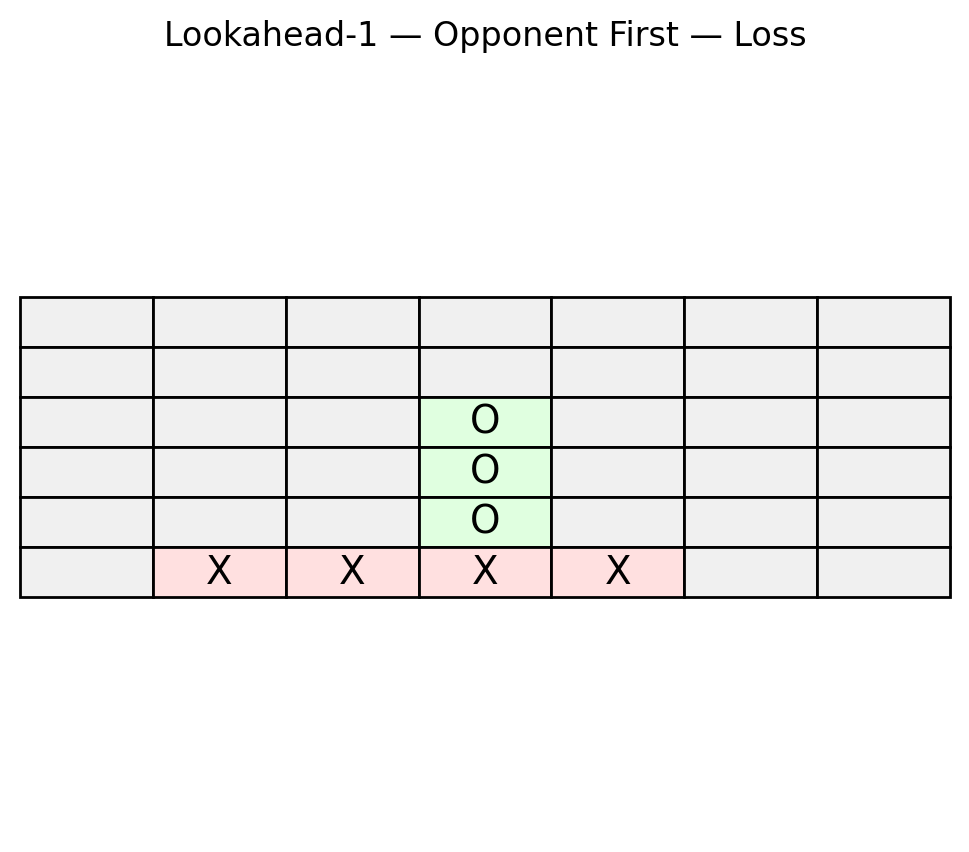

In [24]:
display_final_boards_ppo(policy=policy, env=env, opponents=["Lookahead-1"], lookahead_impl=Lookahead, temperature=0.0)


🎯 Opponent: Lookahead-2


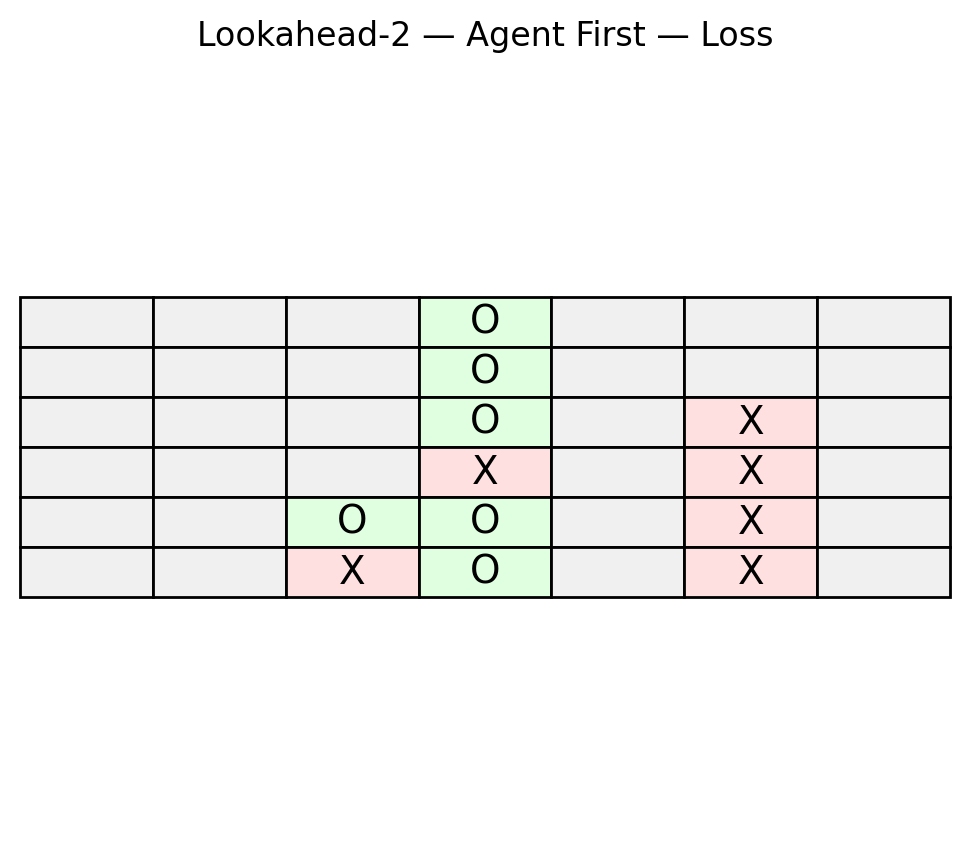

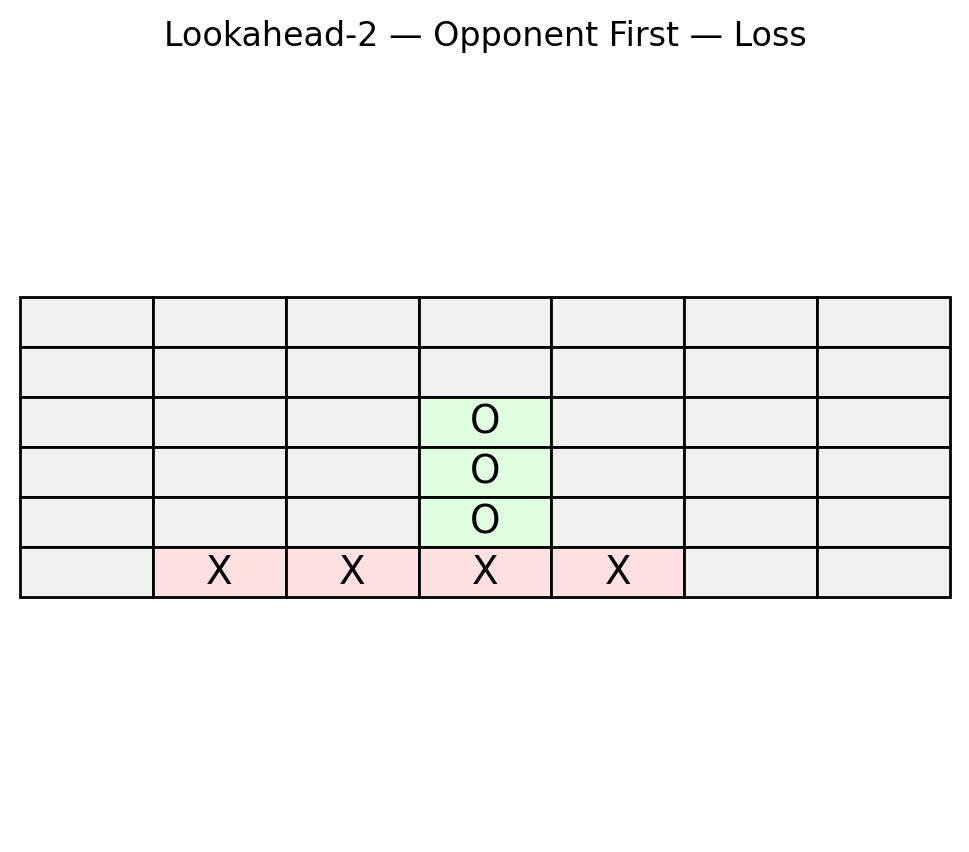

In [25]:
display_final_boards_ppo(policy=policy, env=env, opponents=["Lookahead-2"], lookahead_impl=Lookahead, temperature=0.0)


🎯 Opponent: Lookahead-3


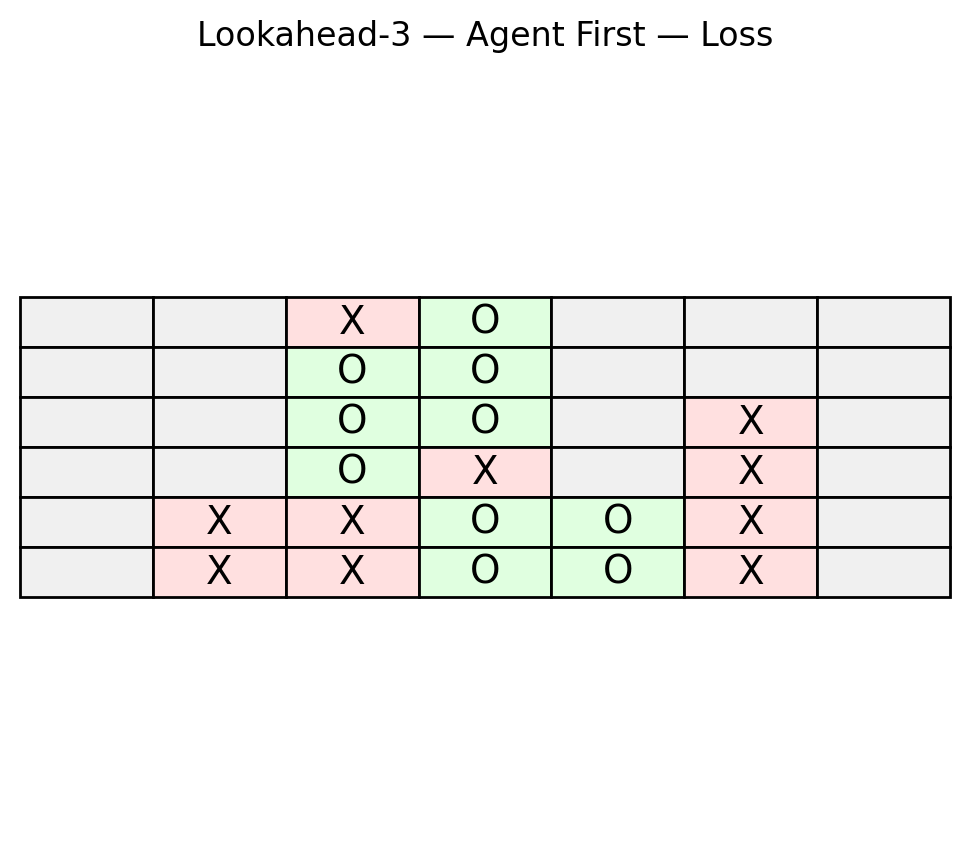

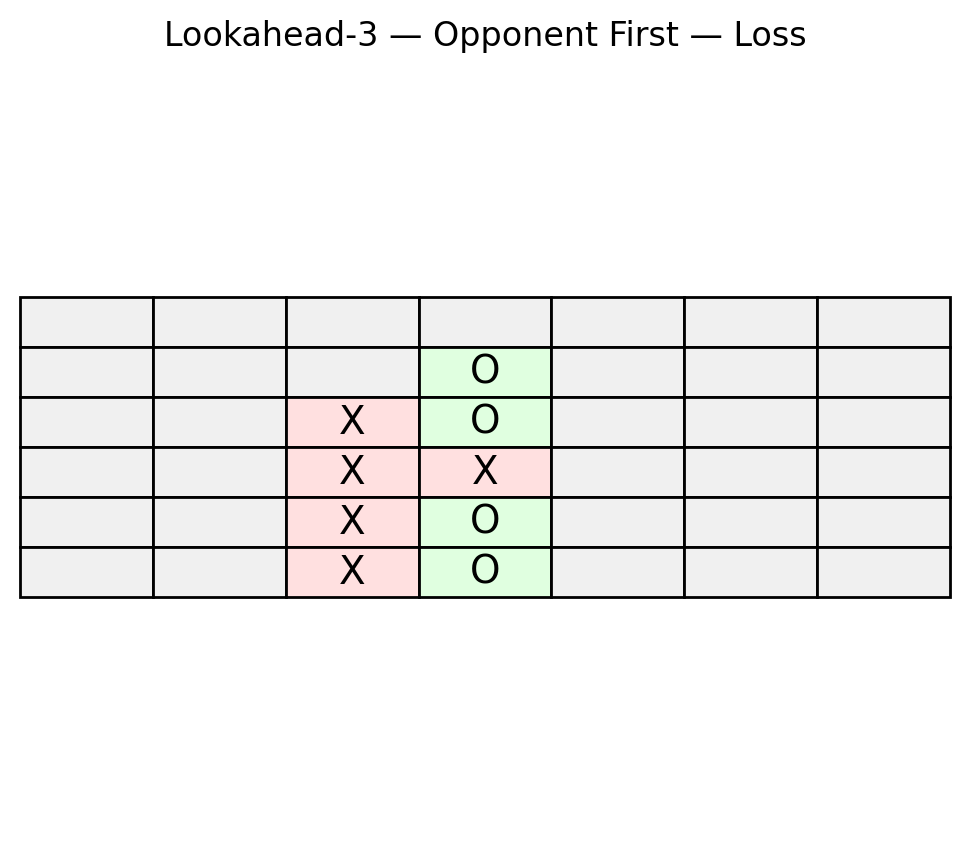

In [26]:
display_final_boards_ppo(policy=policy, env=env, opponents=["Lookahead-3"], lookahead_impl=Lookahead, temperature=0.0)

# DONE

In [27]:
total_end_time = time.time()
total_elapsed = (total_end_time - begin_start_time) / 3600
print(f"Evaluation completed in {total_elapsed:.1f} hours")

Evaluation completed in 0.5 hours


## Training log

In [28]:
# TRAINING_SESSION

training_log_file = "PPO Training_Sessions.xlsx"
log_row = {"TRAINING_SESSION": TRAINING_SESSION, "TIME [h]": total_elapsed, "EPISODES": number_episodes}

for label, stats in evaluation_results.items():
    log_row[label] = stats["win_rate"]

# === Load or Create Excel File ===
if os.path.exists(training_log_file):
    df_log = pd.read_excel(training_log_file)
else:
    df_log = pd.DataFrame()

# === Append and Save ===
df_log = pd.concat([df_log, pd.DataFrame([log_row])], ignore_index=True)
df_log.to_excel(training_log_file, index=False)

print(f"\n📁 Training session logged to: {training_log_file}")


📁 Training session logged to: PPO Training_Sessions.xlsx
